# Figure 2
This will simulate a single participant (with fixed parameter values). They will undergo many simulated experiments, generating datasets for each experiment. For each experiment we will do ML estimation of the Rachlin and the modified-Rachlin functions. We then make scatter plots to visualise the level of ML estimation error.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker
import numpy as np
from scipy.stats import pearsonr

%config InlineBackend.figure_format = 'retina'

import sys
print("Python version:\n{}\n".format(sys.version))

%run set_plot_options.py

from parameters import *
from discount_functions import rachlin, rachlin_kappa
from fitting import MLE_procedure
from model import get_response, calc_log_likelihood
from adaptive_experiment import make_dataset, plot_data

Python version:
3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]



Set the random seed, for reproducibility

In [2]:
np.random.seed(seed=353485)

# Down to business...
We are going to have one set of true parameters, representing one simulated observer. But we will run many experiments on them. They will produce slightly different datasets because of the stochastic nature of their responses. From this, we will get slightly different ML parameter estimates. We will plot the spread of these parameter estimates.

In [3]:
def MLE_inference(nll_func):
    """wrapper function for MLE"""
    bounds = [(0,3), (0,5)]
    fit = MLE_procedure(nll_func, bounds)
    if fit.success==False:
        print('Fit failed :(')
    return fit.x
    
    
# define true parameters
true_s = 0.7
true_k = np.exp(-3)
true_kappa = true_k**(1/true_s)

data_generating_discount_func = rachlin
data_generating_params = [true_s, true_k]

true_params_modified = [true_s, true_kappa]


def many_simulations(N_simulations=500, debug=False):
    MLparams_Rachlin = np.empty([N_simulations, 2])
    MLparams_fixedRachlin = np.empty([N_simulations, 2])
    
    for i in range(N_simulations):
        data = make_dataset(data_generating_discount_func, data_generating_params)

        # create NLL functions to minimise, with the data embedded within them
        def nll_func_rachlin(params):
            return -calc_log_likelihood(data, rachlin, params)

        def nll_func_rachlin_kappa(params):
            return -calc_log_likelihood(data, rachlin_kappa, params)

        MLparams_Rachlin[i,:] = MLE_inference(nll_func_rachlin)
        MLparams_fixedRachlin[i,:] = MLE_inference(nll_func_rachlin_kappa)
        
        if debug:
            fig, ax = plt.subplots()
            plot_data(data, ax)
            delays = np.linspace(0, max(data['DB']), 500)
            ax.plot(delays, data_generating_discount_func(delays, data_generating_params), label='true')
            ax.plot(delays, data_generating_discount_func(delays, MLparams_Rachlin[i,:]), label='Rachlin')
            ax.plot(delays, rachlin_kappa(delays, MLparams_fixedRachlin[i,:]), label='modified Rachlin')
            ax.legend()
    
    return (MLparams_Rachlin, MLparams_fixedRachlin)

In [4]:
MLparams_Rachlin, MLparams_fixedRachlin = many_simulations(N_simulations=200, debug=False)

# Plot the results

In [5]:
# convert into a dictionary so we have the parameters named
MLparams_Rachlin = dict(s=MLparams_Rachlin[:,0],
                        k=MLparams_Rachlin[:,1], 
                        kappa=MLparams_Rachlin[:,1]**(1/MLparams_Rachlin[:,0]))

MLparams_fixedRachlin = dict(s=MLparams_fixedRachlin[:,0],
                             kappa=MLparams_fixedRachlin[:,1])

In [6]:
def plot_param_scatter(ax, params_estimated, params_true, x_key, y_key):
    """plot all the estimated ML params"""
    ax.scatter(x=params_estimated[x_key], 
               y=params_estimated[y_key],
               c='k',
               alpha=0.5)
    
    # ax.autoscale(enable=True, axis='both', tight=True)
    
    # crosshairs for true parameters
    ax.axhline(y=params_true[0])
    ax.axvline(x=params_true[1])

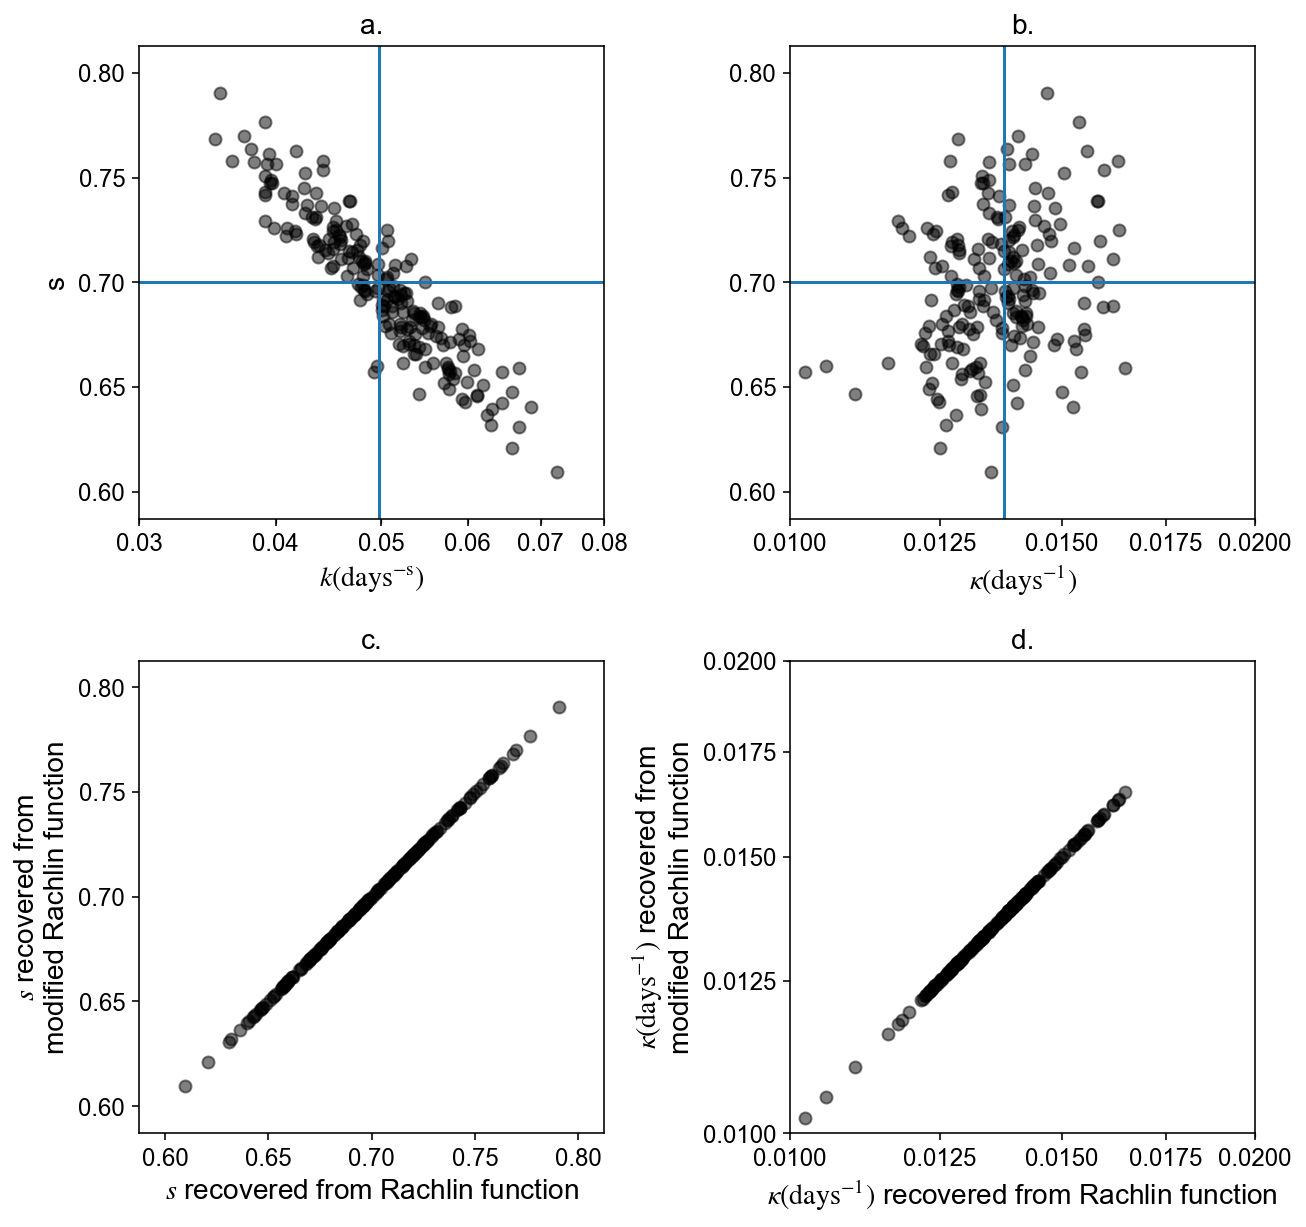

In [19]:
fig1 = plt.figure(figsize=(FIG_WIDTH_INCHES, FIG_WIDTH_INCHES))
gs = gridspec.GridSpec(2, 2)

ax0 = fig1.add_subplot(gs[0,0])
ax1 = fig1.add_subplot(gs[0,1], sharey=ax0)
ax2 = fig1.add_subplot(gs[1,0])
ax3 = fig1.add_subplot(gs[1,1], sharex=ax1)
axes = [ax0, ax1, ax2, ax3]

# rachlin scatterplot here
plot_param_scatter(ax0, MLparams_Rachlin, data_generating_params, 'k', 's')
ax0.set_xscale('log')
ax0.set_title('a.')
ax0.set_xlabel(r'$k (\rm{days}^{-s})$')
ax0.set_ylabel(r's')
# adjust axis ticks
ax0.set_xticks(np.linspace(0.03, 0.08, 6))
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax0.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax0.set_xlim(0.03, 0.08)


# rachlin-modified scatterplot here
plot_param_scatter(ax1, MLparams_fixedRachlin, true_params_modified , 'kappa', 's')
#ax1.set_xlim(0.01, 0.02)
ax1.set_xscale('log')
ax1.set_title('b.')
ax1.set_xlabel(r'$\kappa (\rm{days}^{-1})$')

# # adjust axis ticks
# ax1.set_xticks((0.01, 0.02))
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax1.set_xlim(0.01, 0.02)

# plot s
ax2.set_title('c.')
ax2.scatter(x=MLparams_Rachlin['s'], y=MLparams_fixedRachlin['s'], c='k', alpha=0.5)
ax2.set_xlabel(r'$s$ recovered from Rachlin function')
ax2.set_ylabel('$s$ recovered from\nmodified Rachlin function')


# plot k'
ax3.set_title('d.')
ax3.scatter(x=MLparams_Rachlin['kappa'], y=MLparams_fixedRachlin['kappa'], color='k', alpha=0.5)
ax3.set_xlabel('$\\kappa (\\rm{days}^{-1})$ recovered from Rachlin function', multialignment='center')
ax3.set_ylabel('$\\kappa (\\rm{days}^{-1})$ recovered from\nmodified Rachlin function', multialignment='center')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(ax3.get_xlim())
# adjust axis ticks
ax3.set_xticks(np.linspace(0.01, 0.02, 5))
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.set_xlim(0.01, 0.02)
ax3.set_yticks(np.linspace(0.01, 0.02, 5))
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax3.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.set_ylim(0.01, 0.02)


[ax.title.set_size(BIGGER_SIZE) for ax in axes]

# improve spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.4)

fig1.savefig("Figure2.pdf", bbox_inches='tight', dpi=300)

In [8]:
pearsonr(MLparams_Rachlin['s'], MLparams_fixedRachlin['s'])

(0.9999997773796819, 0.0)

In [9]:
pearsonr(MLparams_Rachlin['kappa'], MLparams_fixedRachlin['kappa'])

(0.9999999837842869, 0.0)